In [1]:
import numpy as np
import scqubits as scq
import matplotlib.pyplot as plt
import qutip as qt
import chencrafts as cc

In [25]:
exp_params = {
    'E_Ja': 4.6,
    'E_Jb': 5.5,
    'E_Ca': 0.9,
    'E_Cb': 0.9,
    'E_J': 3,
    'E_C': 50,
    'ECm': 16.686114352392064,
    'E_L1': 2,
    'E_L2': 2,
    # 'E_La': 0.292,
    # 'E_Lb': 0.287,
    'E_La': 0.21,
    'E_Lb': 0.21,

    'flux_s': 0,
    'flux_c': 0.32,
}


para = exp_params
para["flux_a"] = 0.5 + para["flux_s"]
para["flux_b"] = 0.5 - para["flux_s"]

In [26]:
sim_params = {
    "qa_cutoff": 110,
    "qb_cutoff": 110,
    "p_cutoff": 110,
    "m_cutoff": 110,
    "qa_dim": 5,
    "qb_dim": 5,
    "p_dim": 5,
    "m_dim": 7,
}

In [27]:
circ_yaml = f"""
branches:
# qubit a
- ["JJ", 0, 1, E_Ja = {para["E_Ja"]}, E_Ca = {para["E_Ca"]}]
- ["L", 1, 2, E_La = {para["E_La"]}]

# coupler
- ["C", 0, 2, E_C = {para["E_C"]}]
- ["L", 0, 2, E_L1 = {para["E_L1"]}]
- ["C", 0, 3, E_C]
- ["L", 0, 3, E_L2 = {para["E_L2"]}]
- ["JJ", 2, 3, E_J = {para["E_J"]}, ECm = {para["ECm"]}]

# qubit b
- ["JJ", 0, 4, E_Jb = {para["E_Jb"]}, E_Cb = {para["E_Cb"]}]
- ["L", 3, 4, E_Lb = {para["E_Lb"]}]
"""

ftc = scq.Circuit(circ_yaml, from_file=False)

trans_mat = np.linalg.inv([
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 1, -1, 0],
    [0, 1, 1, 0],
])

brch = ftc.branches
ftc.configure(
    transformation_matrix=trans_mat, 
    system_hierarchy=[[1], [2], [[3], [4]]], 
    subsystem_trunc_dims=[
        sim_params["qa_dim"], 
        sim_params["qb_dim"],
        [sim_params["m_dim"] * 2, [
            sim_params["m_dim"], 
            sim_params["p_dim"]
        ]], 
    ],
    closure_branches=[
        brch[0], brch[7], brch[6]   # flux in junctions
    ],
    # closure_branches=[circ.branches[1], circ.branches[4]]   # flux in inductors
)
ftc.cutoff_ext_1 = sim_params["qa_cutoff"]
ftc.cutoff_ext_2 = sim_params["qb_cutoff"]
ftc.cutoff_ext_3 = sim_params["m_cutoff"]
ftc.cutoff_ext_4 = sim_params["p_cutoff"]

ftc.Φ1 = para["flux_a"]
ftc.Φ2 = para["flux_b"]
ftc.Φ3 = -para["flux_c"]

ftc.sym_hamiltonian()

<IPython.core.display.Latex object>

In [28]:
from typing import Tuple

def find_sweetspot_by_spectrum(
    self,   # the ftc circuit
    flux_c = None, 
    evals_count=4,
    ftol = 1e-8,
    gtol = 1e-8,
    eps = 1e-11,
    mode = "l3",
    flux_s_bounds = [0, 0.1],
    flux_sb_bounds = None,      # if not None, flux_a and b are independent
    flux_c_bounds = [0.25, 0.3],
    run_num = 1,
    **kwargs
) -> Tuple[float, float, float]:
    
    def freq_ab(params, evals_count, mode):
        try:
            self.flux_a = 0.5 + params["flux_s"]
            self.flux_c = params["flux_c"]
            if flux_sb_bounds is None:
                self.flux_b = 0.5 - params["flux_s"]
            else:
                self.flux_b = 0.5 + params["flux_sb"]
        except Exception:
            self.Φ1 = 0.5 + params["flux_s"]
            if flux_sb_bounds is None:
                self.Φ2 = 0.5 - params["flux_s"]
            else:
                self.Φ2 = 0.5 + params["flux_sb"]
            self.Φ3 = params["flux_c"]

        eigs = self.eigenvals(evals_count)
        if mode == "l3":
            return eigs[3] - eigs[0]
        elif mode == "l1+l2":
            return eigs[1] + eigs[2] - 2 * eigs[0]
        elif mode == "l2-l1":
            return np.abs(eigs[2] - eigs[1])
        elif mode == "zz":
            abszz = np.abs(eigs[3] - eigs[2] - eigs[1] + eigs[0])
            return abszz
        elif mode == "l1+l2+zz":
            abszz = np.abs(eigs[3] - eigs[2] - eigs[1] + eigs[0])
            return eigs[1] + eigs[2] - 2 * eigs[0] + 1e-3*abszz
        else:
            raise ValueError("mode not supported")
        
    free_params = {"flux_s": flux_s_bounds, "flux_c": flux_c_bounds}
    if flux_sb_bounds is not None:
        free_params["flux_sb"] = flux_sb_bounds
    
    opt = cc.tb.Optimization(
        {}, free_params,
        freq_ab,
        optimizer="L-BFGS-B",
        target_kwargs={"evals_count": evals_count, "mode": mode},
        opt_options={"ftol": ftol, "gtol": gtol, "disp": False, "eps": eps, "maxls": 100}
    )

    if flux_c is not None:
        opt.fix(flux_c=flux_c)
    
    multi_opt = cc.tb.MultiOpt(opt)
    multi_traj = multi_opt.run(run_num)
    traj = multi_traj.best_traj()

    try:
        self.flux_a = 0.5 + traj.final_full_para["flux_s"]
        self.flux_c = traj.final_full_para["flux_c"]
        if flux_sb_bounds is None:
            self.flux_b = 0.5 - traj.final_full_para["flux_s"]
        else:
            self.flux_b = 0.5 + traj.final_full_para["flux_sb"]
        
        return self.flux_a, self.flux_b, self.flux_c
    except Exception:
        self.Φ1 = 0.5 + traj.final_full_para["flux_s"]
        if flux_sb_bounds is None:
            self.Φ2 = 0.5 - traj.final_full_para["flux_s"]
        else:
            self.Φ2 = 0.5 + traj.final_full_para["flux_sb"]
        self.Φ3 = traj.final_full_para["flux_c"]
        
        return self.Φ1, self.Φ2, self.Φ3


In [29]:
phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        flux_c=0.3,
        flux_s_bounds=[-0.1, 0.1],
        run_num=1,
        mode="l1+l2+zz"
    )

In [30]:
phi1,phi2,phi3

(0.4827500339592362, 0.5172499660407638, 0.3)

In [31]:
import scqubits as scq
from scqubits.utils.cpu_switch import get_map_method

flux_c_values = np.linspace(0., 0.5, 20)  # Create 100 points between 0 and 0.5
evals_array = []

for flux_c in flux_c_values:
    phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        flux_c=flux_c,
        flux_s_bounds=[-0.15, 0.15],
        run_num=1,
        mode="l1+l2+zz"
    )
    evals = ftc.eigenvals(4)
    evals_relative = evals - evals[0]
    evals_array.append(evals_relative)

evals_array = np.array(evals_array)


# Plotting
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(flux_c_values, evals_array[:, i], label=f'Eigenvalue {i+1}')

plt.xlabel('flux_c')
plt.ylabel('Relative Eigenvalues')
plt.title('Eigenvalues vs flux_c')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

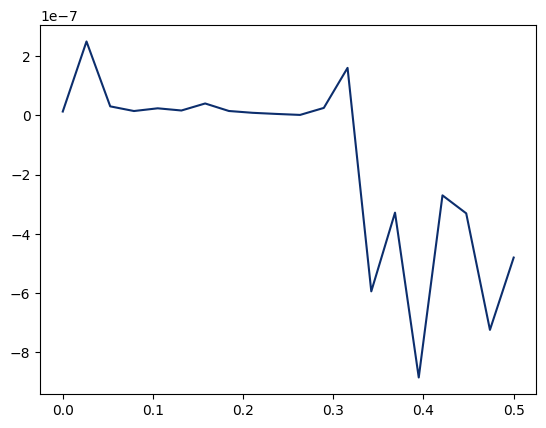

In [24]:
plt.plot(flux_c_values,evals_array[:, 3]-evals_array[:, 2]-evals_array[:, 1])
plt.show()

In [252]:
evals_array[:, 3]-evals_array[:, 2]-evals_array[:, 1]

array([-2.900302e-06, -2.876444e-06, -2.711722e-06, -2.886396e-06, -2.682440e-06, -2.637909e-06, -5.447972e-07, -2.528319e-06,
       -2.375658e-06, -2.742128e-06, -1.098630e-06, -1.947611e-06, -2.293671e-06, -3.942196e-06, -7.551005e-06, -2.082620e-05,
       -1.070341e-04, -8.957078e-04, -3.291328e-03, -1.725285e-04])

In [243]:

phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        # flux_c=0.3,
        flux_s_bounds=[-0.15, 0.15],
        run_num=1,
        flux_c_bounds=[0.4,0.5],
        mode = "l1+l2+zz"
    )

In [244]:
phi1, phi2, phi3

(0.3935979170590708, 0.6064020829409291, 0.465598921071544)

In [245]:
import numpy as np

# Initialize parameters
# ftc.Φ1, ftc.Φ2, ftc.Φ3 = [0.41535310554298277, 0.5846468944570172, 0.36415030940792337]
h = 1e-6  # Small step size for finite differences

# Compute original eigenvalues
evals = ftc.eigenvals() - ftc.eigenvals()[0]

# Function to compute the eigenvalues given parameters
def compute_evals(ftc):
    return ftc.eigenvals() - ftc.eigenvals()[0]

# Initialize the derivative matrix
derivative_matrix = np.zeros((3, 3))

# Compute derivatives w.r.t ftc.Φ1
ftc.Φ1 += h
evals_Φ1_plus = compute_evals(ftc)
ftc.Φ1 -= 2 * h
evals_Φ1_minus = compute_evals(ftc)
ftc.Φ1 += h  # Reset to original value

derivative_matrix[0, 0] = (evals_Φ1_plus[1] - evals_Φ1_minus[1]) / (2 * h)
derivative_matrix[1, 0] = (evals_Φ1_plus[2] - evals_Φ1_minus[2]) / (2 * h)
derivative_matrix[2, 0] = (evals_Φ1_plus[3] - evals_Φ1_minus[3]) / (2 * h)

# Compute derivatives w.r.t ftc.Φ2
ftc.Φ2 += h
evals_Φ2_plus = compute_evals(ftc)
ftc.Φ2 -= 2 * h
evals_Φ2_minus = compute_evals(ftc)
ftc.Φ2 += h  # Reset to original value

derivative_matrix[0, 1] = (evals_Φ2_plus[1] - evals_Φ2_minus[1]) / (2 * h)
derivative_matrix[1, 1] = (evals_Φ2_plus[2] - evals_Φ2_minus[2]) / (2 * h)
derivative_matrix[2, 1] = (evals_Φ2_plus[3] - evals_Φ2_minus[3]) / (2 * h)

# Compute derivatives w.r.t ftc.Φ3
ftc.Φ3 += h
evals_Φ3_plus = compute_evals(ftc)
ftc.Φ3 -= 2 * h
evals_Φ3_minus = compute_evals(ftc)
ftc.Φ3 += h  # Reset to original value

derivative_matrix[0, 2] = (evals_Φ3_plus[1] - evals_Φ3_minus[1]) / (2 * h)
derivative_matrix[1, 2] = (evals_Φ3_plus[2] - evals_Φ3_minus[2]) / (2 * h)
derivative_matrix[2, 2] = (evals_Φ3_plus[3] - evals_Φ3_minus[3]) / (2 * h)

# Print the derivative matrix
print("Derivative matrix:")
print(derivative_matrix)


Derivative matrix:
[[ 1.367031e-03  1.325788e-01 -2.328992e+00]
 [-1.557476e-01 -2.902123e-01  2.322861e+00]
 [-1.041516e-01  3.720370e-01  6.870902e-01]]


In [246]:
# ftc.Φ1, ftc.Φ2, ftc.Φ3 = [0.4823500501369615,0.5176499498630385,0.2647067359584053]
hamiltonian = ftc.hamiltonian().toarray()
charge_op3 = ftc.Q3_operator().toarray()
charge_op4 = ftc.Q4_operator().toarray()

In [247]:
# Extract the diagonal elements of the Hamiltonian and their indices
diag_elements = np.diag(hamiltonian)
indices = np.argsort(diag_elements)

# Sort the Hamiltonian matrix by rearranging rows and columns according to the sorted indices
sorted_hamiltonian = hamiltonian[np.ix_(indices, indices)]

# Apply the same rearrangement to the coupling matrix
charge_op3 = charge_op3[np.ix_(indices, indices)]
charge_op4 = charge_op4[np.ix_(indices, indices)]

In [248]:
evals,U = np.linalg.eigh(sorted_hamiltonian)
Ud = U.transpose().conjugate()
(Ud@charge_op3@U)[:4,:4]


array([[0.+1.906025e-17j, 0.-1.655081e-02j, 0.+1.029987e-02j, 0.-2.203786e-02j],
       [0.+1.655081e-02j, 0.+7.880583e-18j, 0.-5.382020e-03j, 0.+2.781757e-02j],
       [0.-1.029987e-02j, 0.+5.382020e-03j, 0.+1.016080e-17j, 0.-4.054870e-03j],
       [0.+2.203786e-02j, 0.-2.781757e-02j, 0.+4.054870e-03j, 0.+5.193159e-18j]])

In [253]:
(Ud@charge_op4@U)[:4,:4]

array([[0.+3.903300e-19j, 0.+2.911603e-04j, 0.+2.181352e-03j, 0.+1.816826e-04j],
       [0.-2.911603e-04j, 0.-3.377014e-19j, 0.+1.213266e-04j, 0.+7.444763e-04j],
       [0.-2.181352e-03j, 0.-1.213266e-04j, 0.-2.841690e-18j, 0.+1.340759e-03j],
       [0.-1.816826e-04j, 0.-7.444763e-04j, 0.-1.340759e-03j, 0.-1.663361e-18j]])

In [254]:
evals = evals-evals[0]
evals[3]-evals[1]-evals[2]

-0.003020311180510493